In [110]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyspark
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, fbeta_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

import pickle


In [146]:
spark = pyspark.sql.SparkSession.builder \
    .appName("model-training") \
    .master("local[*]") \
    .getOrCreate()

In [147]:
def read_gold_table(table, gold_db, spark):
    """
    Helper function to read all partitions of a gold table
    """
    folder_path = os.path.join(gold_db, table)
    files_list = [os.path.join(folder_path, os.path.basename(f)) for f in glob.glob(os.path.join(folder_path, '*'))]
    df = spark.read.option("header", "true").parquet(*files_list)
    return df


In [148]:
X_spark = read_gold_table('feature_store', 'datamart/gold', spark)
y_spark = read_gold_table('label_store', 'datamart/gold', spark)

In [149]:
X_df = X_spark.toPandas().sort_values(by='customer_id')
y_df = y_spark.toPandas().sort_values(by='customer_id')

In [150]:
print(X_df.shape)
print(y_df.shape)

(8974, 74)
(8974, 5)


In [116]:
# X_df.to_csv('./dataaaa.csv')


In [117]:
print(y_df['loan_id'].nunique())

8974


In [118]:
# sample_feature_store.to_csv('./feature_sample.csv', index=False) 
# sample_label_store.to_csv('./label.csv', index=False) 


In [119]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from typing import Dict, Any

def create_split_config(
    model_train_date_str: str,
    train_test_period_months: int,
    oot_period_months: int,
    train_test_ratio: float
) -> Dict[str, Any]:
    """
    Step 1: Creates a configuration dictionary exactly as defined in the script.
    """
    print("--- Step 1: Creating Split Configuration ---")
    config = {}
    config["model_train_date_str"] = model_train_date_str
    config["train_test_period_months"] = train_test_period_months
    config["oot_period_months"] = oot_period_months
    config["model_train_date"] = datetime.strptime(model_train_date_str, "%Y-%m-%d").date()
    config["oot_end_date"] = config['model_train_date'] - timedelta(days=1)
    config["oot_start_date"] = config['model_train_date'] - relativedelta(months=oot_period_months)
    config["train_test_end_date"] = config["oot_start_date"] - timedelta(days=1)
    config["train_test_start_date"] = config["oot_start_date"] - relativedelta(months=train_test_period_months)
    config["train_test_ratio"] = train_test_ratio
    
    print("Configuration created successfully.")
    return config

def split_data_by_time(
    X_df: pd.DataFrame, 
    y_df: pd.DataFrame, 
    config: Dict[str, Any], 
    date_column='snapshot_date'
) -> Dict[str, pd.DataFrame]:
    """
    Step 2: Performs the primary temporal split into development and OOT sets.
    """
    print("\n--- Step 2: Splitting Data into Primary Time Windows ---")
    
    y_df[date_column] = pd.to_datetime(y_df[date_column]).dt.date
    
    # Filter data to the overall period defined by the config
    y_model_df = y_df[
        (y_df[date_column] >= config['train_test_start_date']) & 
        (y_df[date_column] <= config['model_train_date'])
    ]
    X_model_df = X_df[np.isin(X_df['customer_id'], y_model_df['customer_id'].unique())]

    # Create OOT split
    y_oot = y_model_df[
        (y_model_df[date_column] >= config['oot_start_date']) & 
        (y_model_df[date_column] <= config['oot_end_date'])
    ]
    X_oot = X_model_df[np.isin(X_model_df['customer_id'], y_oot['customer_id'].unique())]

    # Create Train/Test split
    y_traintest = y_model_df[y_model_df[date_column] <= config['train_test_end_date']]
    X_traintest = X_model_df[np.isin(X_model_df['customer_id'], y_traintest['customer_id'].unique())]
    
    print(f"OOT set created with {len(y_oot)} samples.")
    print(f"Development (Train/Test) set created with {len(y_traintest)} samples.")
    
    return {'X_traintest': X_traintest, 'y_traintest': y_traintest, 'X_oot': X_oot, 'y_oot': y_oot}

def prepare_final_arrays(
    primary_splits: Dict[str, pd.DataFrame], 
    config: Dict[str, Any]
) -> Dict[str, Any]:
    """
    Step 3: Performs the final train_test_split and scales the data.
    This function uses shuffle and stratify as defined in the original script.
    """
    print("\n--- Step 3: Preparing and Scaling Final Arrays ---")
    
    X_traintest = primary_splits['X_traintest']
    y_traintest = primary_splits['y_traintest']
    X_oot = primary_splits['X_oot']
    
    # Perform the train_test_split with shuffle and stratify
    X_train, X_test, y_train, y_test = train_test_split(
        X_traintest, y_traintest,
        test_size=config['train_test_ratio'],
        random_state=611,
        shuffle=True,
        stratify=y_traintest['label']
    )
    print("Performed final train-test split.")

    # Drop identifier columns and convert to numpy arrays
    id_cols = ['customer_id', 'snapshot_date']
    X_train_arr = X_train.drop(columns=id_cols).values
    X_test_arr = X_test.drop(columns=id_cols).values
    X_oot_arr = X_oot.drop(columns=id_cols).values
    y_train_arr = y_train['label'].values
    y_test_arr = y_test['label'].values
    y_oot_arr = primary_splits['y_oot']['label'].values

    # Scale the data
    scaler = StandardScaler()
    X_train_arr_scaled = scaler.fit_transform(X_train_arr)
    X_test_arr_scaled = scaler.transform(X_test_arr)
    X_oot_arr_scaled = scaler.transform(X_oot_arr)
    print("Data scaling complete.")

    return {
        'X_train_arr': X_train_arr_scaled,
        'X_test_arr': X_test_arr_scaled,
        'X_oot_arr': X_oot_arr_scaled,
        'y_train_arr': y_train_arr,
        'y_test_arr': y_test_arr,
        'y_oot_arr': y_oot_arr,
        'scaler': scaler
    }



In [120]:
# # 1. Define the configuration for the time splits
logistic_config = create_split_config(
    model_train_date_str="2024-09-02",
    train_test_period_months=12,
    oot_period_months=2,
    train_test_ratio=0.2
)

# # 2. Create the primary time windows (dev and oot)
primary_splits = split_data_by_time(X_df, y_df, logistic_config)

# # 3. Prepare the final, scaled NumPy arrays ready for modeling
model_ready_data = prepare_final_arrays(primary_splits, logistic_config)

--- Step 1: Creating Split Configuration ---
Configuration created successfully.

--- Step 2: Splitting Data into Primary Time Windows ---
OOT set created with 1029 samples.
Development (Train/Test) set created with 5913 samples.

--- Step 3: Preparing and Scaling Final Arrays ---
Performed final train-test split.
Data scaling complete.


In [121]:
model_ready_data.keys()

dict_keys(['X_train_arr', 'X_test_arr', 'X_oot_arr', 'y_train_arr', 'y_test_arr', 'y_oot_arr', 'scaler'])

In [122]:
import numpy as np
import pickle
import os
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from typing import Dict, Any

def train_and_save_model_versioned(
    model_ready_data: Dict[str, np.ndarray],
    output_dir: str = "model_registry"
) -> str:
    """
    Trains a Logistic Regression model and saves it with a timestamp.

    This function takes the pre-scaled, model-ready NumPy arrays, fits the
    model, and saves the final classifier object to a specified directory.
    The filename will include a timestamp for versioning.

    Args:
        model_ready_data (Dict[str, np.ndarray]): A dictionary containing the final
            scaled data arrays, including 'X_train_arr' and 'y_train_arr'.
        output_dir (str): The directory path where the model file will be saved.

    Returns:
        str: The full path to the saved model file.
    """
    print("\n--- Final Step: Training and Saving Versioned Model ---")

    # --- 1. Extract the required arrays from the input dictionary ---
    X_train_arr = model_ready_data['X_train_arr']
    y_train_arr = model_ready_data['y_train_arr']
    
    # --- 2. Train the Logistic Regression model ---
    # This block directly implements the user-provided logic.
    clf = LogisticRegression(random_state=42)
    clf.fit(X_train_arr, y_train_arr)
    print("Model training complete.")

    # --- 3. Create directory and generate timestamped filename ---
    # Ensure the target directory exists
    os.makedirs(output_dir, exist_ok=True)
        
    # Generate a timestamp for the filename (e.g., 20240628_014900)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    file_name = f"logistic_regression_{timestamp}.pkl"
    full_model_path = os.path.join(output_dir, file_name)

    # --- 4. Save the trained model ---
    with open(full_model_path, "wb") as f:
        pickle.dump(clf, f)
    
    print(f"Model successfully saved to: '{full_model_path}'")
    
    return full_model_path




In [124]:
train_and_save_model_versioned(model_ready_data, './model_registry')


--- Final Step: Training and Saving Versioned Model ---
Model training complete.
Model successfully saved to: './model_registry/logistic_regression_20250627_175204.pkl'


'./model_registry/logistic_regression_20250627_175204.pkl'

In [130]:
import numpy as np
import pickle
from typing import Dict, Any
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, fbeta_score, confusion_matrix, ConfusionMatrixDisplay

def load_model(model_path: str) -> Any:
    """
    Loads a saved model from a .pkl file.

    Args:
        model_path (str): Path to the saved .pkl model file.

    Returns:
        The loaded classifier object.
    """
    print("--- Loading Model Artifact ---")
    with open(model_path, "rb") as f:
        clf = pickle.load(f)
    print(f"Model loaded successfully from '{model_path}'")
    return clf

def evaluate_model(clf: Any, model_ready_data: Dict[str, np.ndarray]):
    """
    Evaluates the model and generates plots exactly as specified.

    Args:
        clf (Any): The loaded, trained classifier object.
        model_ready_data (Dict[str, np.ndarray]): The dictionary containing all
            the scaled NumPy arrays ('X_train_arr', 'y_train_arr', etc.).
    """
    print("\n--- Evaluating Model Performance ---")
    
    # Extract arrays from the dictionary
    X_train_arr = model_ready_data['X_train_arr']
    y_train_arr = model_ready_data['y_train_arr']
    X_test_arr = model_ready_data['X_test_arr']
    y_test_arr = model_ready_data['y_test_arr']
    X_oot_arr = model_ready_data['X_oot_arr']
    y_oot_arr = model_ready_data['y_oot_arr']

    # --- Part 1: Predict Probabilities and Calculate AUC ---
    y_pred_proba_train = clf.predict_proba(X_train_arr)[:, 1]
    train_auc = roc_auc_score(y_train_arr, y_pred_proba_train)

    y_pred_proba_test = clf.predict_proba(X_test_arr)[:, 1]
    test_auc = roc_auc_score(y_test_arr, y_pred_proba_test)

    y_pred_proba_oot = clf.predict_proba(X_oot_arr)[:, 1]
    oot_auc = roc_auc_score(y_oot_arr, y_pred_proba_oot)

    print(f"Train AUC: {train_auc:.4f}")
    print(f"Test AUC: {test_auc:.4f}")
    print(f"OOT AUC: {oot_auc:.4f}")

    # --- Part 2: F-beta Score Analysis & Plot ---
    thresholds = np.arange(0.0, 1.0, 0.01)
    beta = 1.5
    f1_scores_train = [fbeta_score(y_train_arr, y_pred_proba_train > t, beta=beta) for t in thresholds]
    f1_scores_test = [fbeta_score(y_test_arr, y_pred_proba_test > t, beta=beta) for t in thresholds]
    f1_scores_oot = [fbeta_score(y_oot_arr, y_pred_proba_oot > t, beta=beta) for t in thresholds]
    best_threshold = thresholds[np.argmax(f1_scores_train)]

    # Plot F-beta Score vs. Threshold
    plt.figure(figsize=(10, 4))
    plt.plot(thresholds, f1_scores_train, label=f"Train F-{beta} Score")
    plt.plot(thresholds, f1_scores_test, label=f"Test F-{beta} Score")
    plt.plot(thresholds, f1_scores_oot, label=f"OOT F-{beta} Score")
    plt.axvline(x=best_threshold, color="red", linestyle="--", label=f"Best Threshold: {best_threshold:.2f}")
    plt.title(f"F-{beta} Score vs. Probability Threshold")
    plt.xlabel("Threshold")
    plt.ylabel(f"F-{beta} Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Part 3: Confusion Matrix Analysis & Plot ---
    # Generate class predictions based on the best threshold from the train set
    y_pred_train = (y_pred_proba_train > best_threshold).astype(int)
    y_pred_test = (y_pred_proba_test > best_threshold).astype(int)
    y_pred_oot = (y_pred_proba_oot > best_threshold).astype(int)

    # Calculate confusion matrices
    cm_train = confusion_matrix(y_train_arr, y_pred_train)
    cm_test = confusion_matrix(y_test_arr, y_pred_test)
    cm_oot = confusion_matrix(y_oot_arr, y_pred_oot)

    # Plot the confusion matrices
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
    disp_train.plot(ax=axs[0], cmap='Blues', colorbar=False)
    axs[0].set_title(f"Train (Threshold={best_threshold:.2f})")
    axs[0].grid(False)

    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
    disp_test.plot(ax=axs[1], cmap='Blues', colorbar=False)
    axs[1].set_title(f"Test (Threshold={best_threshold:.2f})")
    axs[1].grid(False)

    disp_oot = ConfusionMatrixDisplay(confusion_matrix=cm_oot)
    disp_oot.plot(ax=axs[2], cmap='Blues', colorbar=False)
    axs[2].set_title(f"OOT (Threshold={best_threshold:.2f})")
    axs[2].grid(False)

    plt.tight_layout()
    plt.show()

    # --- Part 4: Final F-beta Score Printout ---
    print(f"Best Train F{beta}-Score: {max(f1_scores_train):.4f}")
    print(f"Best Test F{beta}-Score: {max(f1_scores_test):.4f}")
    print(f"Best OOT F{beta}-Score: {max(f1_scores_oot):.4f}")
    
# =====================================================================================
# HOW TO RUN THE FULL PIPELINE (using functions from previous steps):
# =====================================================================================

# Assume you have already run the previous functions.
# You would uncomment and run this section in your main script.

# # 1. Define config, split data, and prepare model-ready arrays
# from your_previous_script import (
#     create_split_config,
#     split_data_by_time,
#     prepare_final_arrays,
#     train_and_save_model_versioned # Or your preferred training function
# )
# config = create_split_config(...)
# primary_splits = split_data_by_time(X_df, y_df, config)
# model_ready_data = prepare_final_arrays(primary_splits, config)

# # 2. Train and save your model
# saved_model_path = train_and_save_model_versioned(model_ready_data)

# # 3. Load the model you just saved
# loaded_model = load_model(saved_model_path)

# # 4. Pass the loaded model and the prepared data to this evaluation function
# evaluate_model(loaded_model, model_ready_data)
# =====================================================================================


In [131]:
log_model = load_model("model_registry/logistic_regression_20250627_175204.pkl")

--- Loading Model Artifact ---
Model loaded successfully from 'model_registry/logistic_regression_20250627_175204.pkl'



--- Evaluating Model Performance ---
Train AUC: 0.8788
Test AUC: 0.8284
OOT AUC: 0.9046


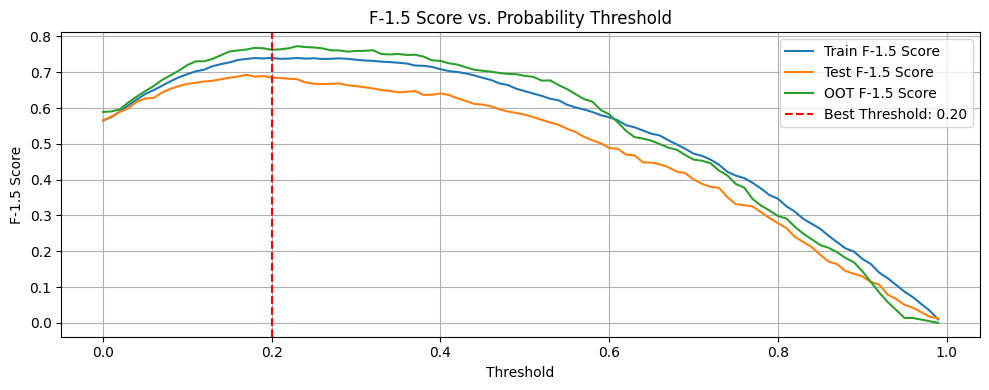

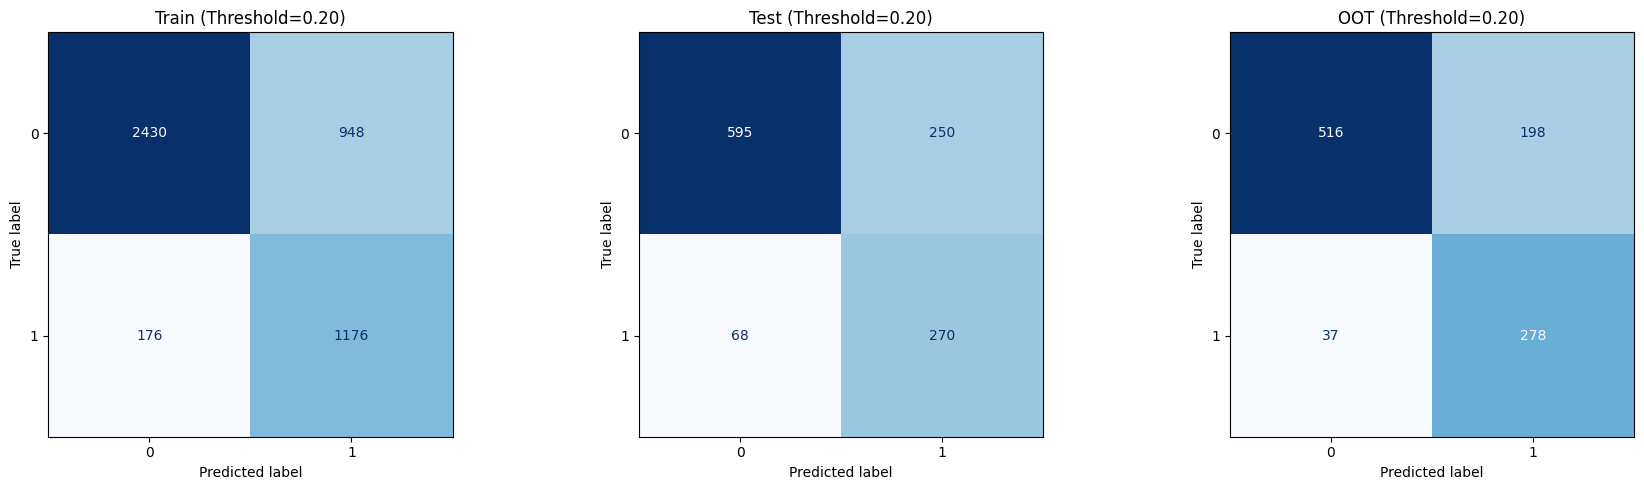

Best Train F1.5-Score: 0.7398
Best Test F1.5-Score: 0.6927
Best OOT F1.5-Score: 0.7728


In [132]:
evaluate_model(log_model, model_ready_data)

In [134]:
print("Row counts for DataFrames in the dictionary:")
print("-" * 40)

# Iterate through the dictionary items (key-value pairs)
for key, df in model_ready_data.items():
    # Check if the value is indeed a pandas DataFrame
    if isinstance(df, pd.DataFrame):
        # Access the number of rows using .shape[0]
        row_count = df.shape[0]
        print(f"Key: '{key}', Row Count: {row_count}")
    else:
        print(f"Key: '{key}' does not contain a pandas DataFrame.")

print("-" * 40)

Row counts for DataFrames in the dictionary:
----------------------------------------
Key: 'X_train_arr' does not contain a pandas DataFrame.
Key: 'X_test_arr' does not contain a pandas DataFrame.
Key: 'X_oot_arr' does not contain a pandas DataFrame.
Key: 'y_train_arr' does not contain a pandas DataFrame.
Key: 'y_test_arr' does not contain a pandas DataFrame.
Key: 'y_oot_arr' does not contain a pandas DataFrame.
Key: 'scaler' does not contain a pandas DataFrame.
----------------------------------------


# XG boost

In [136]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 8.7 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.3/322.3 MB 10.2 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [145]:
print('hellfdfo')

hellfdfo


In [155]:
import pandas as pd
import numpy as np
import pickle
import os
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from typing import Dict, Any, Optional

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, fbeta_score, confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
import matplotlib.pyplot as plt


# =====================================================================================
# STEP 1: CONFIGURATION & DATA PREPARATION FUNCTIONS (Unchanged)
# =====================================================================================

def create_split_config(
    model_train_date_str: str,
    train_test_period_months: int,
    oot_period_months: int
) -> Dict[str, Any]:
    """Creates a configuration dictionary with all necessary date boundaries."""
    print("--- Step 1: Creating Split Configuration ---")
    config = {}
    model_train_date = datetime.strptime(model_train_date_str, "%Y-%m-%d").date()
    config['oot_end_date'] = model_train_date - timedelta(days=1)
    config['oot_start_date'] = model_train_date - relativedelta(months=oot_period_months)
    config['train_test_end_date'] = config['oot_start_date'] - timedelta(days=1)
    config['train_test_start_date'] = config['oot_start_date'] - relativedelta(months=train_test_period_months)
    print(f"Development Period: {config['train_test_start_date']} to {config['train_test_end_date']}")
    print(f"OOT Period: {config['oot_start_date']} to {config['oot_end_date']}")
    return config

def split_data_by_time(
    X_df: pd.DataFrame, 
    y_df: pd.DataFrame, 
    config: Dict[str, Any], 
    date_column='snapshot_date'
) -> Dict[str, pd.DataFrame]:
    """Splits the master data into primary development and OOT sets based on time."""
    print("\n--- Step 2: Splitting Data into Primary Time Windows ---")
    y_df[date_column] = pd.to_datetime(y_df[date_column]).dt.date
    y_model_df = y_df[(y_df[date_column] >= config['train_test_start_date']) & (y_df[date_column] <= config['oot_end_date'])]
    X_model_df = X_df[X_df['customer_id'].isin(y_model_df['customer_id'].unique())]
    y_oot = y_model_df[(y_model_df[date_column] >= config['oot_start_date']) & (y_model_df[date_column] <= config['oot_end_date'])]
    X_oot = X_model_df[X_model_df['customer_id'].isin(y_oot['customer_id'].unique())]
    y_traintest = y_model_df[y_model_df[date_column] <= config['train_test_end_date']]
    X_traintest = X_model_df[X_model_df['customer_id'].isin(y_traintest['customer_id'].unique())]
    print(f"OOT set created with {len(y_oot)} samples.")
    print(f"Development (Train/Val/Test) set created with {len(y_traintest)} samples.")
    return {'X_traintest': X_traintest, 'y_traintest': y_traintest, 'X_oot': X_oot, 'y_oot': y_oot}

def create_development_splits(
    X_traintest: pd.DataFrame, 
    y_traintest: pd.DataFrame, 
    test_ratio: float, 
    validation_ratio: float,
    date_column='snapshot_date'
) -> Dict[str, pd.DataFrame]:
    """Performs a chronological split to create train, validation, and test sets."""
    print("\n--- Step 3: Performing Chronological Splits on Development Data ---")
    y_traintest = y_traintest.sort_values(by=date_column)
    
    test_size = int(len(y_traintest) * test_ratio)
    val_size = int(len(y_traintest) * validation_ratio)
    
    y_test = y_traintest.iloc[-test_size:]
    y_val = y_traintest.iloc[-(test_size + val_size):-test_size]
    y_train = y_traintest.iloc[:-(test_size + val_size)]
    
    y_splits = {'y_train': y_train, 'y_val': y_val, 'y_test': y_test}
    print(f"Split into Train ({len(y_train)}), Validation ({len(y_val)}), and Test ({len(y_test)}) sets.")
    
    final_splits = y_splits.copy()
    for key, y_split in y_splits.items():
        X_key = key.replace('y_', 'X_')
        final_splits[X_key] = X_traintest[X_traintest['customer_id'].isin(y_split['customer_id'].unique())]
        
    return final_splits

def transform_and_scale_data(
    final_splits: Dict[str, pd.DataFrame]
) -> Dict[str, Any]:
    """Converts dataframes to scaled NumPy arrays, ready for modeling."""
    print("\n--- Step 4: Transforming and Scaling Data ---")
    id_cols = ['customer_id', 'snapshot_date']
    results = {}
    
    # Store the original y dataframes before converting to arrays for calculating scale_pos_weight
    results['y_train_df'] = final_splits['y_train']

    for key, df in final_splits.items():
        if key.startswith('y_'):
            results[f'{key}_arr'] = df['label'].values
            
    scaler = StandardScaler()
    # Need to get feature names before converting to numpy array
    feature_names = final_splits['X_train'].drop(columns=id_cols).columns.tolist()
    results['feature_names'] = feature_names

    X_train_arr = final_splits['X_train'].drop(columns=id_cols).values
    results['X_train_arr'] = scaler.fit_transform(X_train_arr)
    print("Scaler fitted on training data.")
    
    for key, df in final_splits.items():
        if key.startswith('X_') and key != 'X_train':
            X_arr = df.drop(columns=id_cols).values
            results[f'{key}_arr'] = scaler.transform(X_arr)
            print(f"Transformed '{key}' data.")
            
    results['scaler'] = scaler
    return results

# =====================================================================================
# STEP 2: **NEW** TUNED XGBOOST TRAINING FUNCTION
# =====================================================================================

def train_xgboost_model_tuned(
    model_ready_data: Dict[str, Any],
    output_dir: str = "model_registry"
) -> str:
    """Trains a tuned XGBoost model with regularization and early stopping."""
    print("\n--- Step 5: Training Tuned XGBoost Model ---")
    
    X_train_arr = model_ready_data['X_train_arr']
    y_train_arr = model_ready_data['y_train_arr']
    X_val_arr = model_ready_data['X_val_arr']
    y_val_arr = model_ready_data['y_val_arr']

    # **IMPROVEMENT 1: Calculate scale_pos_weight for imbalanced data**
    y_train_series = model_ready_data['y_train_df']['label']
    scale_pos_weight = (y_train_series == 0).sum() / (y_train_series == 1).sum()
    print(f"Calculated scale_pos_weight for imbalance: {scale_pos_weight:.2f}")

    # **IMPROVEMENT 2: Add strong regularization hyperparameters**
    clf = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        n_estimators=2000,          # High number for early stopping to find the best
        learning_rate=0.02,         # Lower learning rate
        max_depth=4,                # Shallow trees to prevent overfitting
        subsample=0.7,              # Use 70% of data for each tree
        colsample_bytree=0.6,       # Use 60% of features for each tree
        gamma=1,                    # Regularization term
        reg_alpha=0.1,              # L1 regularization
        reg_lambda=0.1,             # L2 regularization
        scale_pos_weight=scale_pos_weight, # Handle class imbalance
        random_state=42,
        callbacks=[xgb.callback.EarlyStopping(rounds=100, save_best=True)] # More patient early stopping
    )

    clf.fit(
        X_train_arr, 
        y_train_arr,
        eval_set=[(X_val_arr, y_val_arr)],
        verbose=False
    )
    print(f"XGBoost model trained. Best iteration: {clf.best_iteration}")

    os.makedirs(output_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    file_name = f"xgboost_tuned_model_{timestamp}.pkl"
    full_model_path = os.path.join(output_dir, file_name)

    with open(full_model_path, "wb") as f:
        pickle.dump(clf, f)
    
    print(f"Model successfully saved to: '{full_model_path}'")
    return full_model_path, clf

# =====================================================================================
# STEP 3: EVALUATION & FEATURE IMPORTANCE
# =====================================================================================
def plot_feature_importance(clf: Any, feature_names: list):
    """Plots the top 20 most important features from the trained model."""
    print("\n--- Plotting Feature Importance ---")
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 8))
    plt.title("Top 20 Feature Importances")
    plt.barh(range(20), importances[indices][:20][::-1], align='center')
    plt.yticks(range(20), [feature_names[i] for i in indices][:20][::-1])
    plt.xlabel("Feature Importance")
    plt.tight_layout()
    plt.show()

def evaluate_model(clf: Any, model_ready_data: Dict[str, np.ndarray]):
    """Evaluates the model and generates plots for all available data splits."""
    print("\n--- Step 6: Evaluating Model Performance ---")
    
    eval_keys = sorted(list(set([k.replace('_arr', '').replace('X_', '').replace('y_', '') for k in model_ready_data.keys() if k.endswith('_arr')])))
    results = {}
    
    print("--- AUC Scores ---")
    for key in eval_keys:
        y_pred_proba = clf.predict_proba(model_ready_data[f'X_{key}_arr'])[:, 1]
        auc = roc_auc_score(model_ready_data[f'y_{key}_arr'], y_pred_proba)
        results[key] = {'y_true': model_ready_data[f'y_{key}_arr'], 'y_pred_proba': y_pred_proba, 'auc': auc}
        print(f"{key.capitalize()} AUC: {auc:.4f}")

    thresholds, beta = np.arange(0.0, 1.0, 0.01), 1.5
    train_f_scores = [fbeta_score(results['train']['y_true'], results['train']['y_pred_proba'] > t, beta=beta) for t in thresholds]
    best_threshold = thresholds[np.argmax(train_f_scores)]
    
    plt.figure(figsize=(10, 5))
    for key, res in results.items():
        f_scores = [fbeta_score(res['y_true'], res['y_pred_proba'] > t, beta=beta) for t in thresholds]
        plt.plot(thresholds, f_scores, label=f"{key.capitalize()} F-{beta} Score")
    plt.axvline(x=best_threshold, color="red", linestyle="--", label=f"Best Threshold: {best_threshold:.2f}")
    plt.title(f"F-{beta} Score vs. Probability Threshold"), plt.xlabel("Threshold"), plt.ylabel(f"F-{beta} Score"), plt.legend(), plt.grid(True), plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(1, len(eval_keys), figsize=(6 * len(eval_keys), 5), squeeze=False)
    print(f"\n--- Performance at Threshold = {best_threshold:.2f} ---")
    for i, key in enumerate(eval_keys):
        y_pred = (results[key]['y_pred_proba'] > best_threshold).astype(int)
        disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(results[key]['y_true'], y_pred))
        disp.plot(ax=axs[0, i], cmap='Blues', colorbar=False)
        axs[0, i].set_title(f"{key.capitalize()} Set"), axs[0, i].grid(False)
        print(f"{key.capitalize()} F-{beta} Score: {fbeta_score(results[key]['y_true'], y_pred, beta=beta):.4f}")
    plt.tight_layout()
    plt.show()

--- Step 1: Creating Split Configuration ---
Development Period: 2023-07-02 to 2024-07-01
OOT Period: 2024-07-02 to 2024-09-01

--- Step 2: Splitting Data into Primary Time Windows ---
OOT set created with 1029 samples.
Development (Train/Val/Test) set created with 5913 samples.

--- Step 3: Performing Chronological Splits on Development Data ---
Split into Train (3549), Validation (1182), and Test (1182) sets.

--- Step 4: Transforming and Scaling Data ---
Scaler fitted on training data.
Transformed 'X_val' data.
Transformed 'X_test' data.
Transformed 'X_oot' data.

--- Step 5: Training XGBoost Model ---
XGBoost model trained. Best iteration: 1
Model successfully saved to: 'model_registry/xgboost_model_20250627_181227.pkl'

--- Step 6: Evaluating Model Performance ---
--- AUC Scores ---
Oot AUC: 0.4458
Test AUC: 0.4988
Train AUC: 0.7563
Val AUC: 0.5384


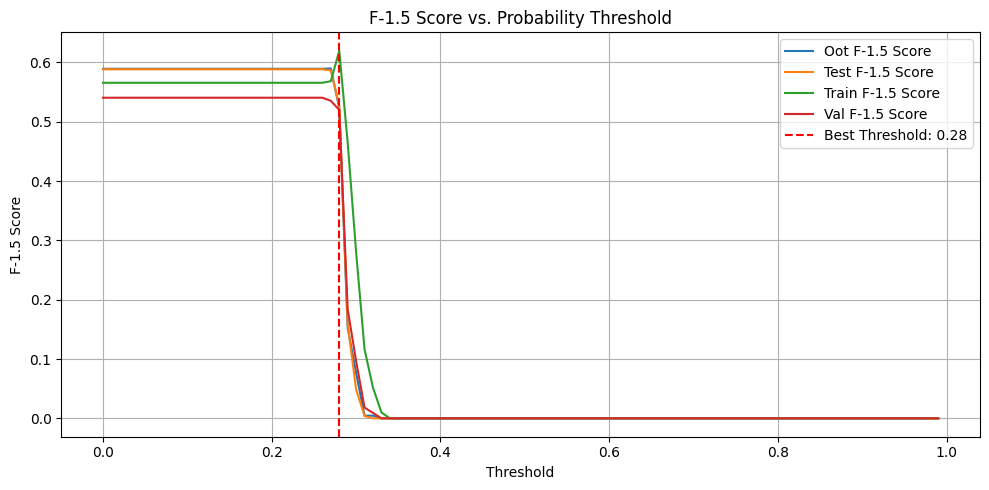


--- Performance at Threshold = 0.28 ---
Oot F-1.5 Score: 0.5231
Test F-1.5 Score: 0.5277
Train F-1.5 Score: 0.6196
Val F-1.5 Score: 0.5198


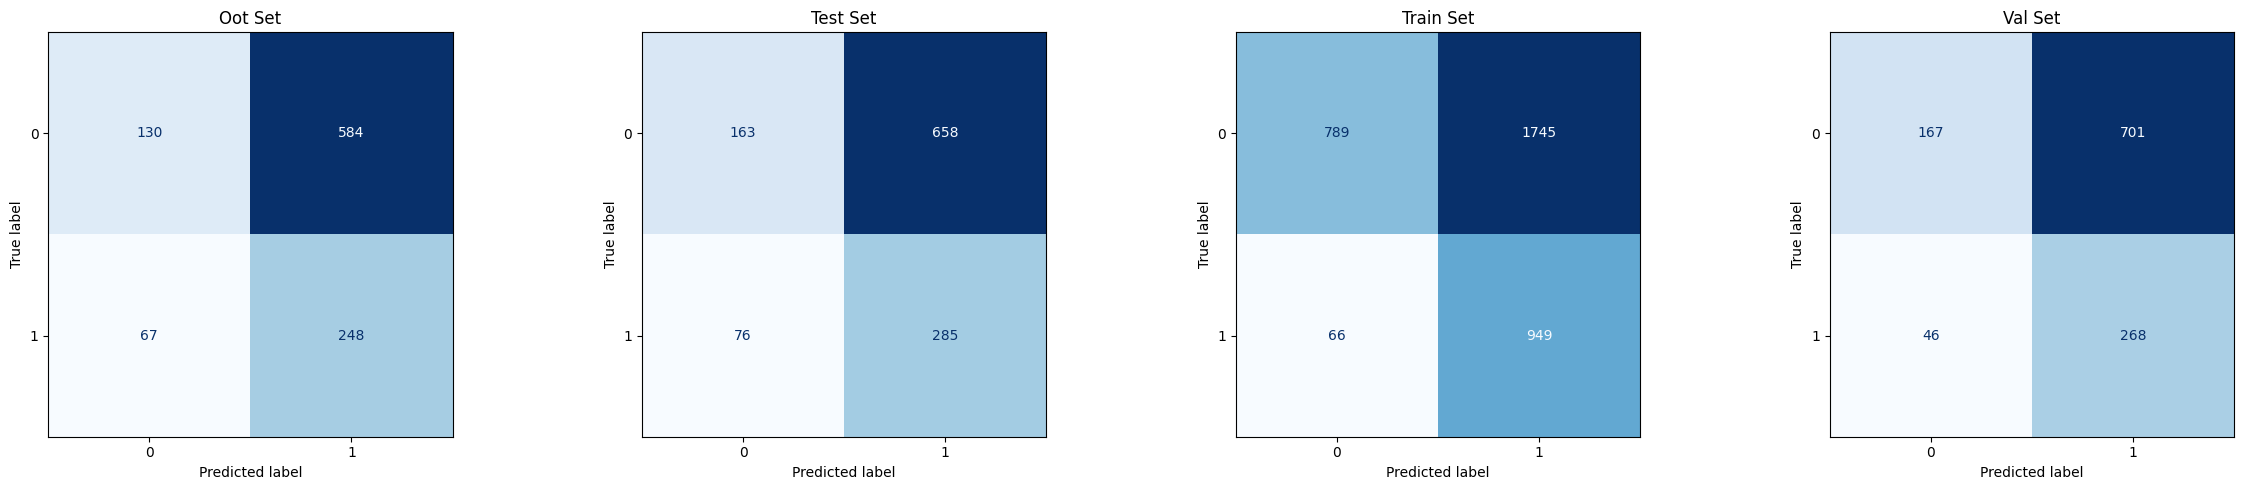

In [156]:
# 1. Define the configuration for the time splits
config = create_split_config(
    model_train_date_str="2024-09-02",
    train_test_period_months=12,
    oot_period_months=2
)

# 2. Create the primary time windows (dev and oot)
primary_splits = split_data_by_time(X_df, y_df, config)

# 3. Create the final chronological splits, including a validation set
final_splits = create_development_splits(
    X_traintest=primary_splits['X_traintest'],
    y_traintest=primary_splits['y_traintest'],
    test_ratio=0.2,
    validation_ratio=0.2 # Use 20% of dev data for validation
)
final_splits['X_oot'] = primary_splits['X_oot']
final_splits['y_oot'] = primary_splits['y_oot']

# 4. Transform and scale all data splits
model_ready_data = transform_and_scale_data(final_splits)

# 5. Train and save the XGBoost model
saved_model_path = train_xgboost_model(model_ready_data)

# 6. Load the saved model
with open(saved_model_path, 'rb') as f:
    loaded_model = pickle.load(f)

# 7. Evaluate the loaded model against all data splits
evaluate_model(loaded_model, model_ready_data)
